In [1]:
# hidden
%config Completer.use_jedi = False

# Differential photometry

After an observation is done, a common need is to reduce and extract fluxes from raw FITS images. 

In this tutorial you will learn how to process a complete night of raw data from any telescope with some basic reduction tools provided by *prose*.

## Example data

you can follow this tutorial on your own data or generate a synthetic dataset with

In [2]:
from prose.datasets import generate_prose_reduction_dataset

fits_folder = generate_prose_reduction_dataset("./tutorial_dataset")

## Telescope setting

We start by setting up the `Telescope` information we need for the reduction, for example some fits keywords that are specific to this observatory plus few specs:

In [3]:
from prose import Telescope

_ = Telescope({
    "name": "NTM",
    "trimming": [40, 40],
    "pixel_scale": 0.66,
    "latlong": [31.2027, 7.8586],
    "keyword_light_images": "light"
})

Telescope 'ntm' saved


This has to be done **only once** and saves this telescope settings for any future use (whenever its name appears in fits headers). More details are given in the [telescope settings](../api/telescope.rst) note.

## Folder exploration

The first thing we want to do is to see what is contained within our folder. For that we instantiate a `FitsManager` object on our folder to describe its content

In [4]:
from prose import FitsManager

fm = FitsManager(fits_folder, depth=2)
fm.calib

100%|██████████| 85/85 [00:00<00:00, 598.16it/s]

╒════════════╤════════════════╤══════════╤══════════╤════════╤════════════╕
│ date       │ telescope      │ target   │ filter   │ type   │   quantity │
╞════════════╪════════════════╪══════════╪══════════╪════════╪════════════╡
│ 2020-02-29 │ fake_telescope │          │          │ bias   │          1 │
├────────────┼────────────────┼──────────┼──────────┼────────┼────────────┤
│ 2020-02-29 │ fake_telescope │          │          │ dark   │          1 │
├────────────┼────────────────┼──────────┼──────────┼────────┼────────────┤
│ 2020-02-29 │ fake_telescope │          │ I+z      │ flat   │          3 │
├────────────┼────────────────┼──────────┼──────────┼────────┼────────────┤
│ 2020-02-29 │ fake_telescope │ prose    │ I+z      │ light  │         80 │
╘════════════╧════════════════╧══════════╧══════════╧════════╧════════════╛



/Users/lionelgarcia/Code/envs/prose/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


We have 80 images of the *prose* target together with some calibration files. More info about the `FitsManager` object [here](./fits_manager.ipynb).

## Reduction and Photometry

*prose* provides basic pipelines for reduction and photometry. Using these, the `Reduction` is simply

In [5]:
from prose import Reduction

reduction = Reduction(fm)
reduction.run()

RUN Reduction: 100%|█████████████████████████| 80/80 [00:03<00:00, 25.95files/s]


The previously set telescope has been recognized and a ``fake_telescope_20200229_prose_I+z`` folder has been created in which we can now run the `AperturePhotometry`.

In [6]:
from prose import AperturePhotometry

photometry = AperturePhotometry(reduction.destination)
photometry.run()

100%|██████████| 81/81 [00:00<00:00, 901.54it/s]


INFO detected stars: 7
INFO global psf FWHM: 2.10 (pixels)


RUN Photometry: 100%|████████████████████████| 80/80 [00:04<00:00, 19.50files/s]


Here is the content of the reduced folder:

```
fake_telescope_20200229_prose_I+z/
  │ 
  ├── fake_telescope_20200229_prose_I+z.phot
  ├── fake_telescope_20200229_prose_I+z_movie.gif
  ├── fake-C001-002020-03-01T00:00:00.000_reduced.fits
  ├── fake-C001-002020-03-01T00:01:00.000_reduced.fits
  ├── fake-C001-002020-03-01T00:02:00.000_reduced.fits
  └── ...
```

It contains:

- all reduced images
- a ``phot`` file containing all extracted fluxes and stack image (see [data products description](./phot.ipynb))
- a ``gif`` of the night 

`Reduction` and `AperturePhotometry` are `Unit` objects modularly built out of `Block`. Such pipelines can be built from scratch and even contain custom `Block` (like in the [next tutorial](./custom_pipeline.ipynb)).

## Photometry analysis

Let's load our data into an `Observation` object containing all we need for this analysis and show the detected stars

INFO Time converted to BJD TDB


<Figure size 432x288 with 0 Axes>

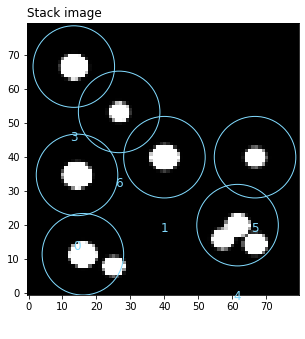

In [7]:
from prose import load

obs = load(photometry.phot_path)
obs.show_stars(size=5)

In [8]:
obs

<xarray.Dataset>
Dimensions:          (apertures: 40, h: 80, n: 2, star: 7, time: 80, w: 80)
Coordinates:
    stack            (w, h) float64 255.4 254.8 256.7 ... 255.3 257.1 256.6
  * time             (time) float64 2.459e+06 2.459e+06 ... 2.459e+06 2.459e+06
    stars            (star, n) float64 14.28 34.79 40.0 ... 40.0 26.67 53.33
Dimensions without coordinates: apertures, h, n, star, w
Data variables:
    fluxes           (apertures, star, time) float64 2.624e+09 ... 9.914e+10
    errors           (apertures, star, time) float64 6.038e+06 ... 2.281e+08
    sky              (time) float64 255.6 255.6 255.8 ... 255.8 255.4 255.7
    fwhm             (time) float64 1.843 1.978 1.978 1.844 ... 1.84 1.843 1.978
    fwhmx            (time) float64 1.843 1.978 1.978 1.844 ... 1.84 1.843 1.978
    fwhmy            (time) float64 1.843 1.978 1.978 1.844 ... 1.84 1.843 1.978
    dx               (time) float64 1.791e-05 1.097e-05 ... -2.581e-05 8.698e-05
    dy               (time) float64 3.648e-05 4.203e-05 ... 2.038e-05 -2.93e-05
    airmass          (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    exptime          (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    jd_utc           (time) float64 2.459e+06 2.459e+06 ... 2.459e+06 2.459e+06
    seeing           (time) object '' '' '' '' '' '' '' ... '' '' '' '' '' '' ''
    ra               (time) float64 12.84 12.84 12.84 ... 12.84 12.84 12.84
    dec              (time) float64 -22.86 -22.86 -22.86 ... -22.86 -22.86
    apertures_area   (time, apertures) float64 0.1387 1.699 ... 1.346e+03
    annulus_area     (time) float64 540.9 540.9 540.9 ... 540.9 540.9 540.9
    apertures_radii  (time, apertures) float64 0.2101 0.7354 ... 20.17 20.7
    annulus_rin      (time) float64 10.51 10.51 10.51 ... 10.51 10.51 10.51
    annulus_rout     (time) float64 16.81 16.81 16.81 ... 16.81 16.81 16.81
    bjd_tdb          (time) float64 2.459e+06 2.459e+06 ... 2.459e+06 2.459e+06
Attributes:
    target:       -1
    aperture:     -1
    telescope:    fake_telescope
    filter:       I+z
    exptime:      1
    name:         prose
    date:         20200229
    SIMPLE:       1
    BITPIX:       -64
    NAXIS:        2
    NAXIS1:       80
    NAXIS2:       80
    TELESCOP:     fake_telescope
    EXPTIME:      1
    FILTER:       I+z
    OBJECT:       prose
    IMAGETYP:     Stack image
    AIRMASS:      1
    JD:           2459000.021097046
    RA:           12.84412
    DEC:          -22.85886
    DATE-OBS:     2020-03-01T00:40:00.000
    WCSAXES:      2
    CRPIX1:       0.0
    CRPIX2:       0.0
    CDELT1:       1.0
    CDELT2:       1.0
    CRVAL1:       0.0
    CRVAL2:       0.0
    LATPOLE:      90.0
    WCSNAME:      DEFAULTS
    MJD-OBS:      58909.027777778
    REDDATE:      2021-01-27T15:20:06.748
    NIMAGES:      80
    FWHM:         2.1011221564037954
    FWHMX:        2.0011752899174646
    FWHMY:        2.201069022890126
    PSFANGLE:     0.0
    FWHMALG:      Gaussian2D
    time_format:  bjd_tdb

<div class="alert alert-info">

Note

More details on the structure of these data products (and the representation above) in [data products description](./phot.ipynb)

</div>

If target was not specified in the reduction process (with a value of -1 as shown above), we need to specify it before producing our differential Photometry.

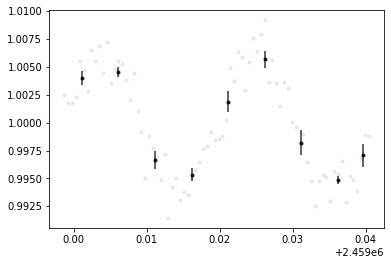

In [9]:
obs.target = 1
df = obs.broeg2005()
df.plot()

<div class="alert alert-info">

Note

We could also have picked the comparison stars ourselves using ``diff`` from `Observation`

</div>

We used the Broeg 2005 algorithm to build the differential light-curve and ended by plotting it. We can check the comparison stars with

<Figure size 432x288 with 0 Axes>

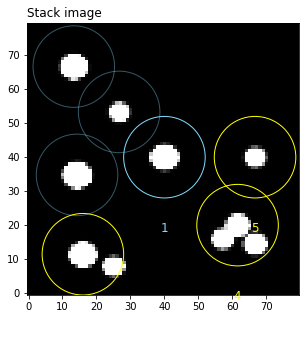

In [10]:
df.show_stars(size=5)

and continue with further visualisation or analysis. All available plotting and analysis methods are described in `Observation`.

To save your analysis into the same phot file

In [11]:
df.save()

In [12]:
# hidden
from shutil import rmtree

rmtree(reduction.destination)
rmtree(fits_folder)